## Ultimate Challenge

Please refer each for answers


In [1]:
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from collections import defaultdict
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
sns.set(rc={"figure.figsize": (18, 6), 'legend.fontsize': 18}) # figsize and leg fontsize of seaborn plots
plt.rc('axes' , labelsize=18)                                  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('axes' , titlesize=18)                                  # fontsize of the plot title

## Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

OK, so we will start by reading in the file and doing some quick exploration.



In [3]:
logins = pd.read_json('logins.json')
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
logins.describe()


,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


So, we can see this data is just login times. Interestingly, there are duplicates. Presumably there are many users in this dataset. Also note, this data only comprises 3.5 months, starting on the first of January to about the middle of April. 

We can now visualize the data, in the prompted 15minute aggregation.


In [5]:

logins.set_index('login_time', inplace=True)
logins['login'] = 1

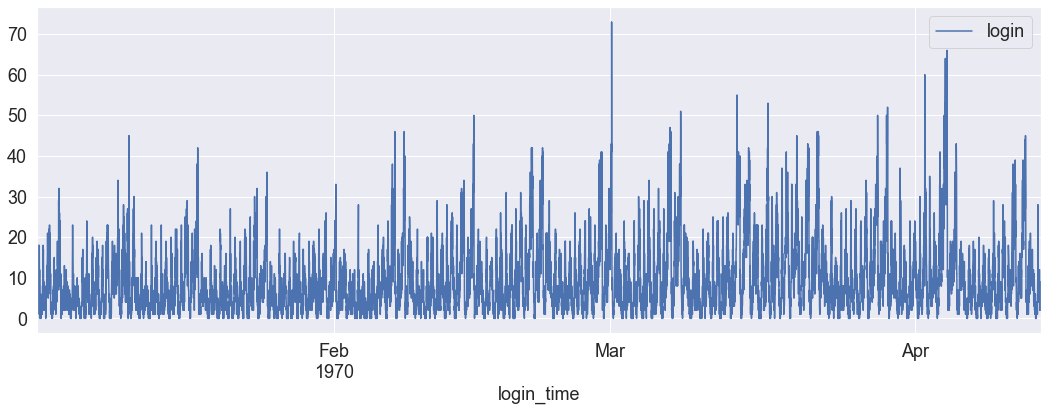

In [6]:
logins.resample('15T').sum().plot()
plt.show()

There certainly seems to be a rhythm to the data, even with the usual spikes. We can use a seasonal decomposition (from statsmodels) to test this theory a little.



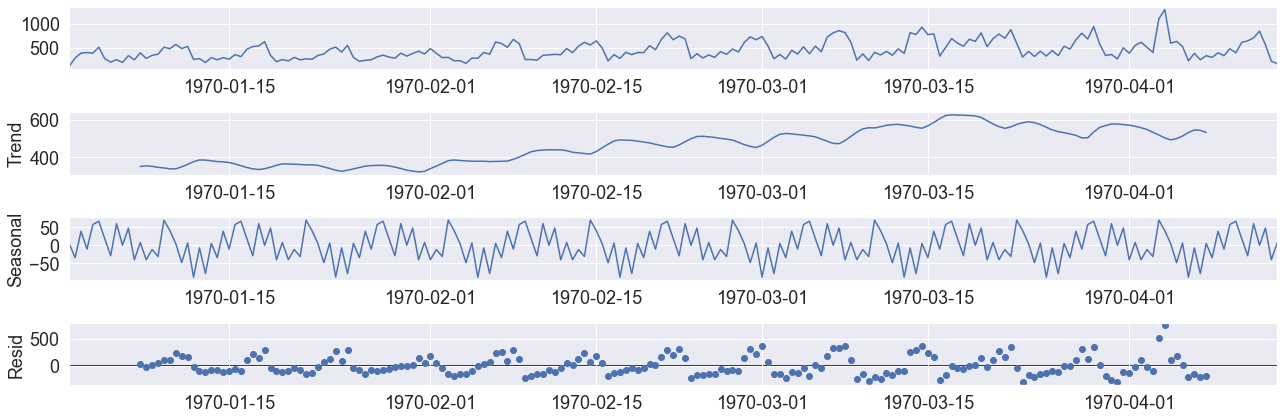

In [7]:
decomposition = sm.tsa.seasonal_decompose(logins.resample('12H').sum())
decomposition.plot()
plt.show()

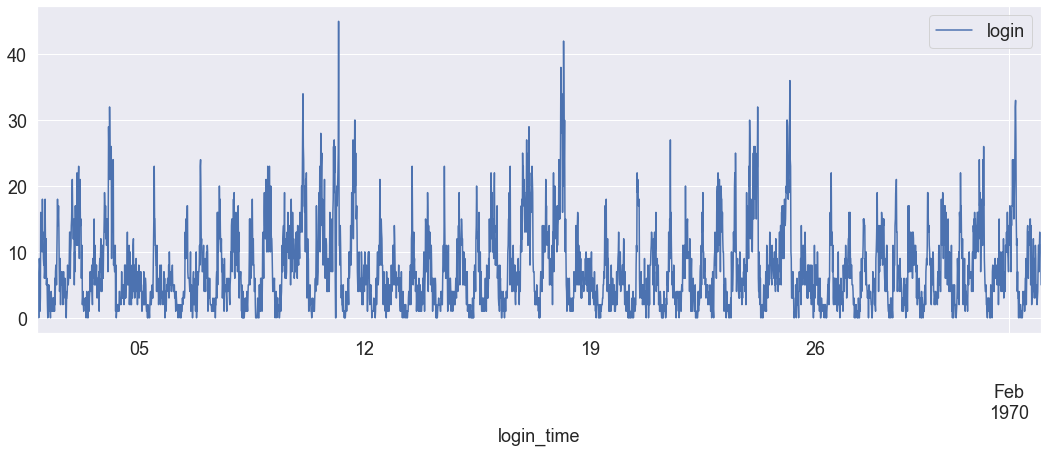

In [8]:

logins.resample('15T').sum()['1970-01-01':'1970-02-01'].plot()
plt.show()

We can see there is a little seasonality at the scale of 12 hours. There is a clear upwards trend, driven in part by the spikes in the later months. We can also zoom in a little for the next two plots: first month and first week.

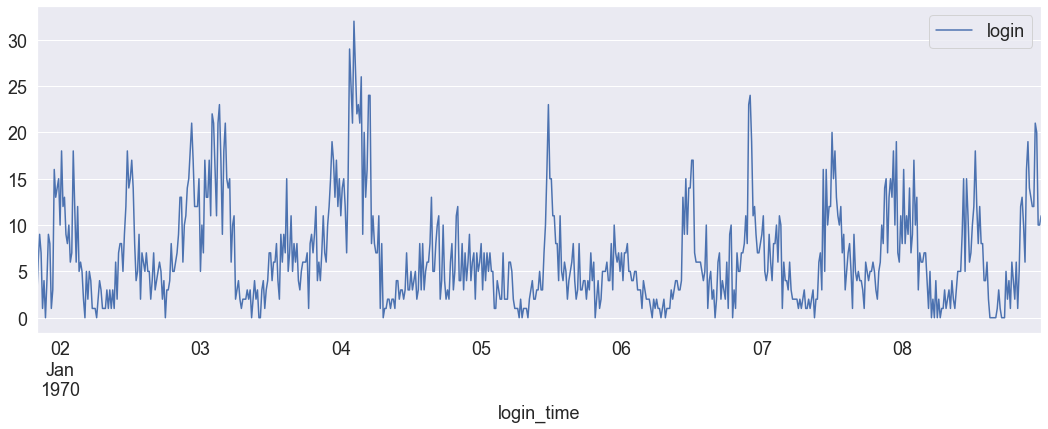

In [9]:

logins.resample('15T').sum()['1970-01-01':'1970-01-08'].plot()
plt.show()


We can see there is a fairly consistent 12-hour theme. 

The spikes are not consistent in size, but the pattern seems to be there; 

Since we see these patterns, we can look at the patterns per day. 
That is we can plot, in 15 minute intervals, the login times for only Mondays, then Tuesdays, etc. This way we can see if there is a consistent pattern throughout all the weeks of the dataset.



In [10]:
resample_15 = logins.reset_index().set_index('login_time').groupby(pd.Grouper(freq='15T')).count()



In [11]:
resample_daily_list = []
for group in resample_15.groupby(pd.Grouper(freq='D')):
    resample_daily_list.append(group[1])

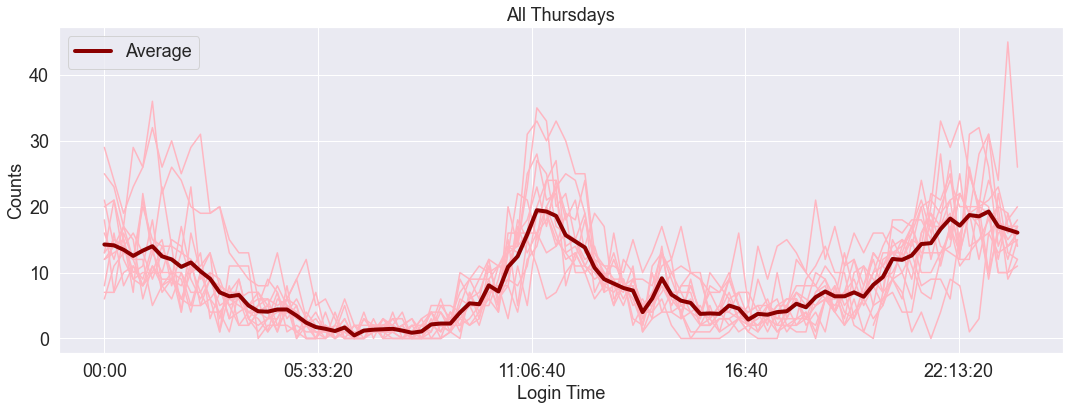

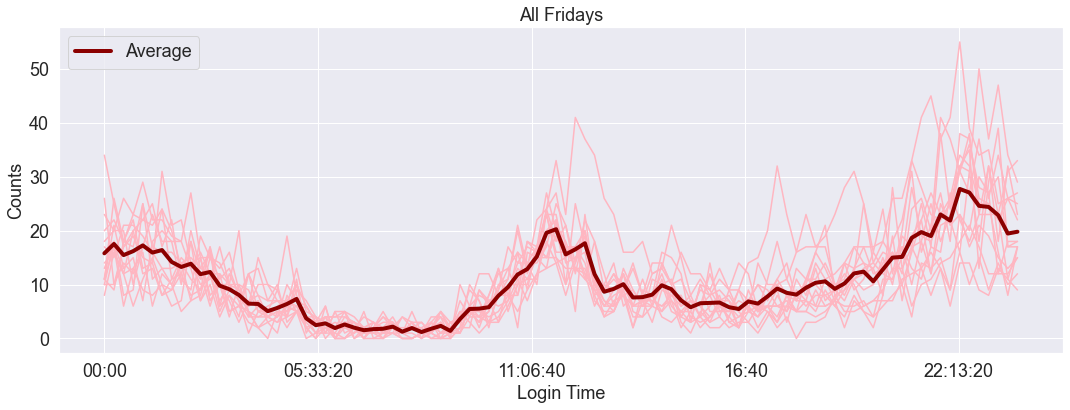

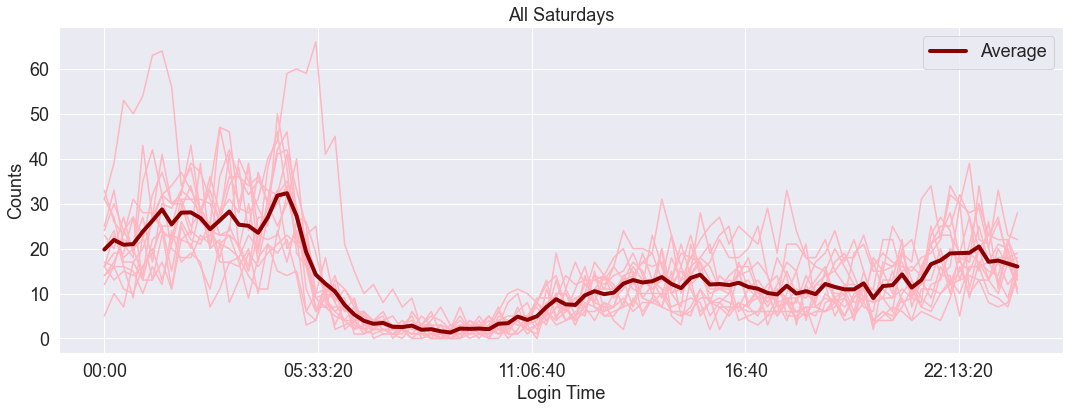

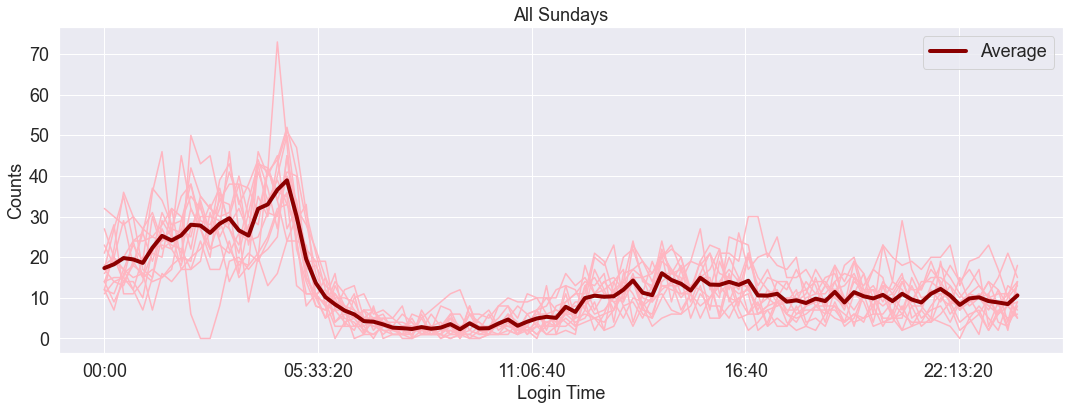

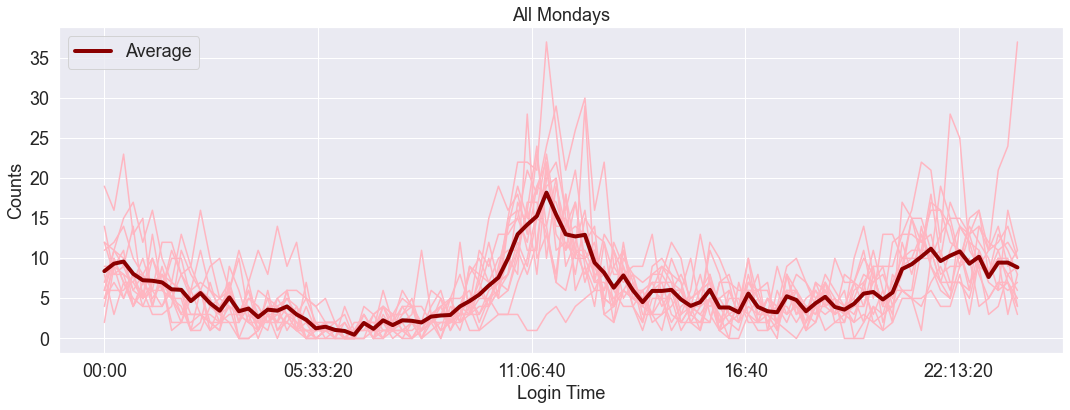

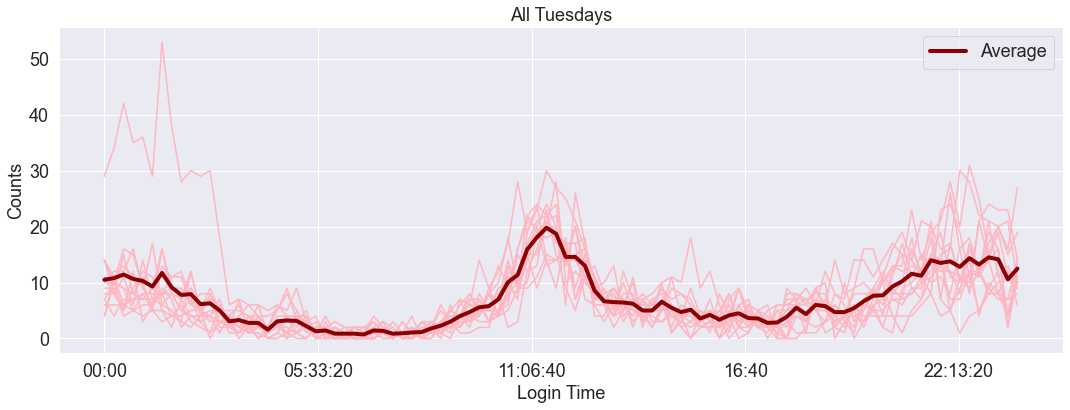

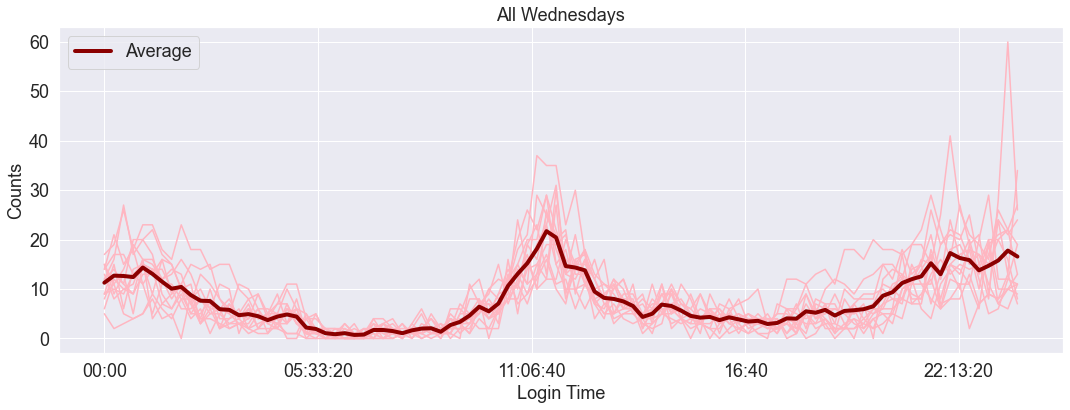

In [12]:
#The days to loop over
day_list = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday']    

#Create a dict for holding the running counts 
avg_index = defaultdict(int)
for i, t in enumerate(pd.timedelta_range(0, periods=24*4, freq='15T')):
    avg_index[i] = datetime.datetime.strptime(str(t).replace('0 days ',''), '%H:%M:%S').time()

#Loop over the 7 days    
for i in range(len(day_list)):
    
    #Create the dataframe to hold the running counts
    avg_df = pd.DataFrame(avg_index.items(), columns=['login', 'login_time'])
    avg_df.login = 0
    avg_df.set_index('login_time', inplace=True)
    
    #Run through grouped day list
    day_range = range(i, len(resample_daily_list), len(day_list))
    for j in day_range:

        #Extract the dataframe
        df = resample_daily_list[j]
        df = df.set_index(df.index.to_series().dt.time)
        
        #Add the values of this dataframe to running count
        avg_df = avg_df.add(df, fill_value=0)              
        
        #Plot the time series
        if j < len(day_list):
            ax = df.plot(legend=False, color='lightpink')
        else:
            df.plot(ax=ax, legend=False, color='lightpink')
            
    #Create the average and plot    
    avg_df['Average'] = avg_df.login/float(len(day_range))
    avg_df.drop('login', axis=1, inplace=True)
    avg_df.plot(ax=ax, legend=True, color='darkred', lw=4.)
    
    #Plot the full graph
    ax.set_title('All ' + day_list[i] + 's')
    ax.set_xlabel('Login Time')
    ax.set_ylabel('Counts')
    plt.show()

The above plots make the 12 hour cycles much easier to see. We can also see that they generally only occur during the week.

A different pattern is seen on the weekend, where the spike is late at night.

As for potential data concerns, there are outliers during any given day that is quite unlike the rest. For instance, on the Tuesday plot, there is a large spike between 12 and 3 AM. This could be bad data, or it could be due to some sort of incident or event. We would have to check historical events to confirm this type of data.

## Part 2 - Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

Question 1: What woud you choose as the key measure of success of this experiment in encouraging driver partners to server both cities, and why would you choose this metric?

Question 2: Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. How you will implement the experiment
b. What statistical test(s) you will conduct to verify the significance of the observation
c. How would you interpret the results and provide recommendations to the city operations team along with any caveats.

Answer 1:

The metric for success will be profit, but other metrics include:

Positive User Feedback
More traffic in cities, which may lead to indirect profit of neighboring stores or restaraunts
Increase signups and registration of users
Less wait times
There's many reasons to choose a metric, and it ultimately comes down to what the city needs. I believe that creating these tolls roads will hopefully increase the awareness about the benefits of driver partners. The goal is to save time and increase productivity

Answer 2:

One simple experiment that we can perform is to conduct an A/B Test. The control group would be users that do not use the toll bridge. And the test group would be users that do use the toll bridge. We'll have to keep track of the revenue gained from both sides and compare it against each other within a few months. Or if you want a more accurate reading, we can collect the data within a year's time.

A statistical test that we can use is applying a t-test, with a p-value of (0.5).

There's three ways to interpret the results. One would be if there's no increase in profit. If this happens, then we'll need to conduct more studies and see what's causing the problem. If there is no increase in profit, then we'll have to wait it out and see what else can be done. If there is profit, then we can look at what factors contributed the most to an increase in profit and maybe optimize from there.

In the end, it'll be hard to evaluate the performance of this experiment within a short period of time. This experiment will have to be monitored for a while and adjustments will have to be made yearly or periodically at the least.

## Part 3 - Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

In [13]:
#Load json info
with open('ultimate_data_challenge.json') as f:
    ultimate = json.load(f)

#Convert to dataframe
ultimate = pd.DataFrame(ultimate)

#Convert the time series to datetimes appropriately
ultimate.signup_date = pd.to_datetime(ultimate.signup_date)
ultimate.last_trip_date = pd.to_datetime(ultimate.last_trip_date)

ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [14]:
ultimate.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [15]:
ultimate.describe()


,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [16]:
ultimate[['signup_date', 'last_trip_date']].describe()


,signup_date,last_trip_date
count,50000,50000
unique,31,182
top,2014-01-18 00:00:00,2014-06-29 00:00:00
freq,2948,2036
first,2014-01-01 00:00:00,2014-01-01 00:00:00
last,2014-01-31 00:00:00,2014-07-01 00:00:00


In [17]:
ultimate['city'].value_counts()


Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [18]:
ultimate['phone'].value_counts()


iPhone     34582
Android    15022
Name: phone, dtype: int64

We've looked at the various columns and seen some descriptive statistics. There are 50,000 rows but there are null values, so we will have to worry about that. We can also see from the two time series columns that the data ranges about 6 months from January 1 to July 1, of 2014. 

There are two categorical variables, city and phone. Each of these only has three and two categories, respectively.

We can now also make histograms of the numeric variables to better understand their distributions

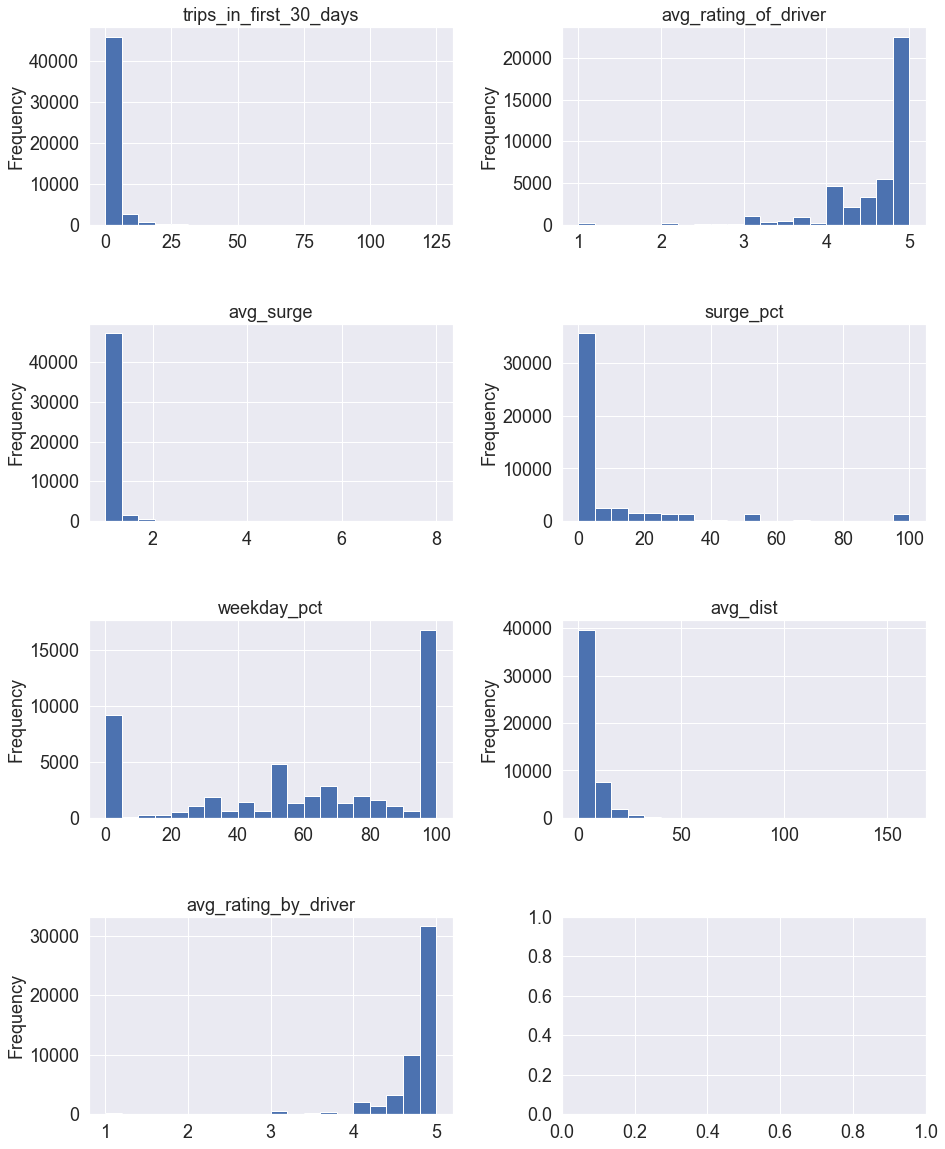

In [19]:
fig, axes = plt.subplots(4, 2, figsize=(15,20))

#Cycle through all relevant columns
i = 1
for col in ultimate.select_dtypes(include=[np.float64, np.int64]).columns:
    plt.subplot(4, 2, i)
    ultimate[col].plot.hist(title=col, logy=False, bins=20)
    i += 1

#Show
fig.subplots_adjust(hspace=0.5, wspace=0.3)    
plt.show()

There is heavy skew in most of the above plots. So let's also make box plots to see what kinds of outliers might exist in this dataset.



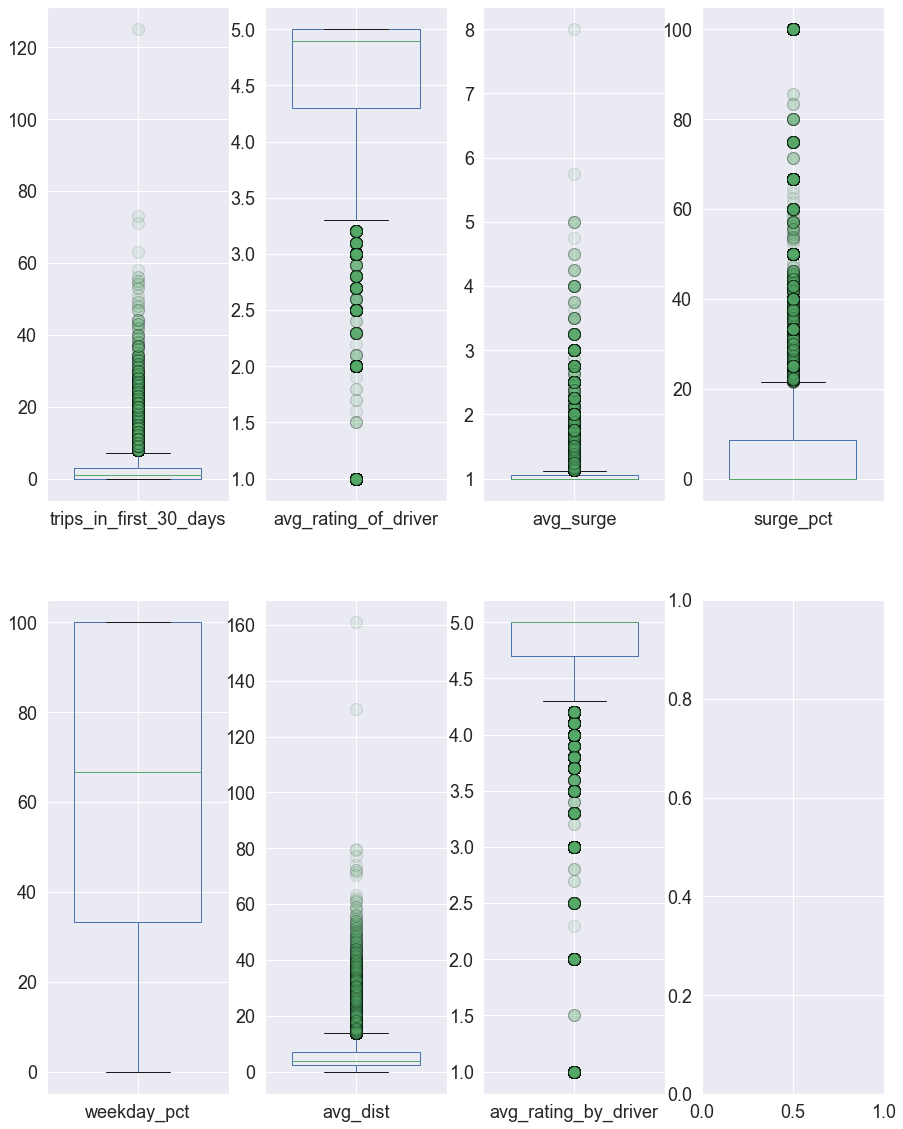

In [20]:
#Make subplotted figure
fig, axes = plt.subplots(2, 4, figsize=(15,20))

#Cycle through all relevant columns
i = 1
for col in ultimate.select_dtypes(include=[np.float64, np.int64]).columns:
    plt.subplot(2, 4, i)
    ultimate[col].plot.box(widths=0.7, flierprops=dict(markerfacecolor='g', markersize=12, alpha=0.1), vert=True)
    i += 1

#Show
plt.show()

There is in fact a large amount of outlier because of the heavy one-sidedness in the distributions. 

We can probably remove some of the rows associated with some of these extreme values.

However, we must keep in mind that because of the heavy skew many outliers should be expected. In that vein, we will remove outliers outside a standard deviation of 4 from the mean for each column. 

First, we can do a quick check to see how many outliers would be removed with this process.



In [21]:
def remove_outliers(df, col, num_sd=4.):
    return df[np.abs(df[col] - df[col].mean()) <= (num_sd * df[col].std())]

In [22]:
outlier_list = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 
                'trips_in_first_30_days']

for col in outlier_list:
    total = len(remove_outliers(ultimate, col))
    print('%-25s : %i (%2.1f%%)' % (col, total, total*100./len(ultimate)))

avg_dist                  : 49539 (99.1%)
avg_rating_by_driver      : 49451 (98.9%)
avg_rating_of_driver      : 41397 (82.8%)
avg_surge                 : 49272 (98.5%)
surge_pct                 : 48584 (97.2%)
trips_in_first_30_days    : 49441 (98.9%)


These results make sense, so we can go ahead and remove those outliers.



In [23]:
for col in outlier_list:
    ultimate = remove_outliers(ultimate, col)

ultimate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39422 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    39422 non-null  object        
 1   trips_in_first_30_days  39422 non-null  int64         
 2   signup_date             39422 non-null  datetime64[ns]
 3   avg_rating_of_driver    39422 non-null  float64       
 4   avg_surge               39422 non-null  float64       
 5   last_trip_date          39422 non-null  datetime64[ns]
 6   phone                   39141 non-null  object        
 7   surge_pct               39422 non-null  float64       
 8   ultimate_black_user     39422 non-null  bool          
 9   weekday_pct             39422 non-null  float64       
 10  avg_dist                39422 non-null  float64       
 11  avg_rating_by_driver    39422 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

We can see that we've removed almost 10k+ rows. There are also a few hundred null values in the phone column still. 

Though we could impute values, we can go ahead and drop those columns as well, since we already dropped so many rows.



In [24]:
ultimate.dropna(inplace=True)
ultimate.reset_index(drop=True, inplace=True)

ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39141 entries, 0 to 39140
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    39141 non-null  object        
 1   trips_in_first_30_days  39141 non-null  int64         
 2   signup_date             39141 non-null  datetime64[ns]
 3   avg_rating_of_driver    39141 non-null  float64       
 4   avg_surge               39141 non-null  float64       
 5   last_trip_date          39141 non-null  datetime64[ns]
 6   phone                   39141 non-null  object        
 7   surge_pct               39141 non-null  float64       
 8   ultimate_black_user     39141 non-null  bool          
 9   weekday_pct             39141 non-null  float64       
 10  avg_dist                39141 non-null  float64       
 11  avg_rating_by_driver    39141 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

This gives us our final dataset consisting of about 39,000 rows (from the original 50,000). Now let's see how many users remained active. We can go through the data and determine which users remain active. Then we can add that information to our dataset.



In [25]:
active_dict = {x:False for x in range(0, len(ultimate))}

#Loop over rows
for i in range(len(ultimate)):
    
    #Set the start date of this row
    start = ultimate['signup_date'][i]
    
    #Set the end date for this row: 6 months later
    end = start + pd.Timedelta('181D')
    
    #Set the time window, a month before end date
    previous = end - pd.Timedelta('30D')
    
    #Was the last trip within the last month?
    if previous <= ultimate['last_trip_date'][i] <= end:
        active_dict[i] = True

#What is the percentage of active users?
num_active = np.sum(list(active_dict.values()))
print('There are %i (%2.1f%%) active users.' % (num_active, num_active*100./len(active_dict))) 

#Add active user info to the dataframe
ultimate['is_active'] = pd.DataFrame(active_dict.items(), columns=['ind', 'active'])['active']

There are 10806 (27.6%) active users.


We can see there are a little more than a quarter of the users that are still active.

Part 3.2 -We can now setup a machine learning model to determine which users will be active 6 months after initially signing up. Let's remind ourselves of the dataset that we have.



In [26]:
ultimate.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39141 entries, 0 to 39140
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    39141 non-null  object        
 1   trips_in_first_30_days  39141 non-null  int64         
 2   signup_date             39141 non-null  datetime64[ns]
 3   avg_rating_of_driver    39141 non-null  float64       
 4   avg_surge               39141 non-null  float64       
 5   last_trip_date          39141 non-null  datetime64[ns]
 6   phone                   39141 non-null  object        
 7   surge_pct               39141 non-null  float64       
 8   ultimate_black_user     39141 non-null  bool          
 9   weekday_pct             39141 non-null  float64       
 10  avg_dist                39141 non-null  float64       
 11  avg_rating_by_driver    39141 non-null  float64       
 12  is_active               39141 non-null  bool  

In [27]:
ultimate.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)


We also have two categorical columns. We can turn these columns into indicator, or dummy, variables.



In [28]:
ultimate = pd.get_dummies(ultimate, drop_first=False)
ultimate.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'is_active', 'city_Astapor',
       'city_King's Landing', 'city_Winterfell', 'phone_Android',
       'phone_iPhone'],
      dtype='object')

We now have 14 columns total, in our dataset. Recall, our target variable is the is_active column, which determines which users remained active. The rest are the predictor variables.

In [29]:
target = 'is_active'

#Extract values for the data
x = ultimate.drop(target, axis=1).values
y = ultimate[target].values

#Get the predictor variable columns
df_columns = ultimate.drop(target, axis=1).columns.values

In [30]:
#Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1221, stratify=y)

print('The train data has %.0f rows which is %.2f%% of the total. ' % (len(x_train), len(x_train)*100./len(ultimate)))
print('The  test data has %.0f rows which is %.2f%% of the total. ' % (len(x_test),  len(x_test) *100./len(ultimate)))

The train data has 31312 rows which is 80.00% of the total. 
The  test data has 7829 rows which is 20.00% of the total. 


Likewise, we will setup a stratified kfold strategy for our cross-validated scoring that we will do.



In [31]:
the_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1220)


In [32]:
score_func = make_scorer(roc_auc_score, greater_is_better=True)


Now we can focus on the actual machine learning algorithm. 

We can use the Random Forest algorithm here since it is a good general-purpose model. It can be a good first-pass at the data. 

It also has the benefit of giving us a ranking of the most predictive features of the dataset. 

A simple logistic regression is also a good algorithm to use as it is likely the most simple. The coefficients derived from this algorithm can also be used to determine the best features.

We can setup a 5-fold CV strategy to find the optimum parameters for the algorithm.

In [33]:
#Setup the RF object
rf = RandomForestClassifier(criterion='gini', class_weight='balanced', n_jobs=-1)

#Hyperparameter grid
param_grid = {'n_estimators' : [40, 50, 60], 'min_samples_split' : [2, 3, 4], 
              'max_depth' : [4, 7, 10]}

#Setup the Gridsearch
rf_cv = GridSearchCV(rf, param_grid, cv=the_cv, scoring=score_func, verbose=1)

#Fit the data
rf_cv.fit(x_train, y_train)

#Print out the best model
print('Best RF Params: {}'.format(rf_cv.best_params_))
print('Best RF Score : %f' % rf_cv.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.4min finished


Best RF Params: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 50}
Best RF Score : 0.733571


In [34]:
rf_best = RandomForestClassifier(criterion='gini', class_weight='balanced', n_jobs=-1, 
                                 n_estimators=rf_cv.best_params_['n_estimators'],
                                 min_samples_split=rf_cv.best_params_['min_samples_split'], 
                                 max_depth=rf_cv.best_params_['max_depth'])

rf_best.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=50,
                       n_jobs=-1)

In [35]:
#Print the score/metric for the input model which must be fit
def get_scores(model, name='unk', score=roc_auc_score):
    
    #Make prediction for the model
    pred = model.predict(x_test)
    pred_prob = model.predict_proba(x_test)[:,1]

    #Calculate the score on the entire test set
    auc = score(y_test, pred_prob)
    
    #Calculate the score on CV test set
    cv_scores = cross_val_score(model, x_test, y_test, cv=the_cv, scoring=score_func)
    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()
    
    #Save to dataframe to be used for printing only
    model_score = pd.DataFrame(columns=['Model', 'Test score', 'CV score'])
    model_score.loc[0] = [name, auc, mean_cv]
    model_score.set_index('Model', inplace=True)
    print(model_score)

In [36]:
get_scores(rf_best, 'RF')


       Test score  CV score
Model                      
RF       0.801257   0.73045


We can now see that the CV test score is similar to the train score. This is reassuring, that there is not heavy overfitting the data. We can be relatively confident of our trained model and its validity.



Part 3.3

Given our trained model, we can now also get the feature importances from the Random Forest algorithm. We can do that below, in graphical and tabular form.

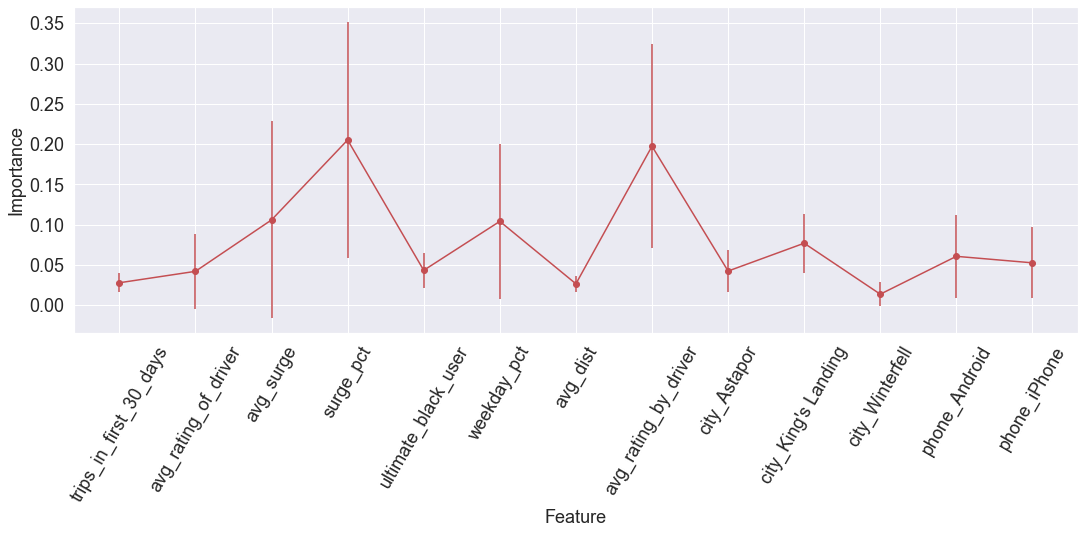

In [37]:
#Calculate std of feature importances
rf_std  = np.std([tree.feature_importances_ for tree in  rf_best.estimators_], axis=0)

#Plot with error bars (and x-offset)
plt.errorbar(np.arange(len(df_columns)), rf_best.feature_importances_, 
             yerr= rf_std, fmt='o-r', label='RF')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(np.arange(len(df_columns)), df_columns, rotation=60)

plt.show()

In [38]:

pd.DataFrame(zip(df_columns, rf_best.feature_importances_), columns=['Feature','Value']).\
   sort_values('Value', ascending=False).reset_index(drop=True)

,Feature,Value
0,surge_pct,0.205255
1,avg_rating_by_driver,0.197467
2,avg_surge,0.105998
3,weekday_pct,0.104206
4,city_King's Landing,0.077064
5,phone_Android,0.060785
6,phone_iPhone,0.052710
7,ultimate_black_user,0.043422
8,city_Astapor,0.042506
9,avg_rating_of_driver,0.042156


From the feature importances, we can see that the two most important predictors are the surge_pct & avg_rating_by_driver. 

This makes sense, because a high surge_pct means lots of using the Ultimate service. Coupled with an emphasis on the rating by the driver, and the high volume users tend to stay on the service. 

This is confirmed by the weekday_pct being the fourth highest predictor. It means users who also use Ultimate during the weekend, tend to use it all the time, thereby increasing their chances of being retained.